<a href="https://colab.research.google.com/github/DMXMax/covid19/blob/gc_20200315/coviddata.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests,json
import datetime


In [0]:
covidtrackingurl = "https://covidtracking.com/api/v1/states/daily.json"
response = requests.get(covidtrackingurl)
dfCovidtracking = pd.DataFrame(response.json())
dfCovidtracking.fillna(0, inplace=True)
dfCovidtracking.negative = dfCovidtracking.negative.astype('int64')
dfCovidtracking.positive = dfCovidtracking.positive.astype('int64')
dfCovidtracking.pending = dfCovidtracking.pending.astype('int64')
dfCovidtracking.total = dfCovidtracking.total.astype('int64')
dfCovidtracking.death = dfCovidtracking.death.astype('int64')

dfCovidtracking.date = dfCovidtracking.date.transform(lambda x: pd.to_datetime(datetime.date(x//10000, x%10000//100, x%100
                                          )))


In [0]:
dfWHO = pd.read_csv("https://raw.githubusercontent.com/DMXMax/covid19/master/who/who_data.tsv",
                     sep='\t', index_col='Date')

In [0]:
jhurl = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/"+\
"csse_covid_19_data/csse_covid_19_daily_reports/05-05-2020.csv"


dfJHUData = pd.read_csv(jhurl, header=0,
                        names=['FIPS', 'city','state', 'country', 'last_update',
                               'lat', 'lon','confirmed', 'dead', 'recovered','active', 'key'])

In [0]:
dfWHO = dfWHO.rename(columns={"Confirmed": "confirmed", "Deaths": "who_deaths"})
dfWHO.index.names=['date']


In [6]:
dfCovidtracking.loc[dfCovidtracking.date==dfCovidtracking.date.max(),\
  ['state', 'positive', 'negative', 'totalTestResults']].sort_values(by='positive', ascending=False).head(10)

,state,positive,negative,totalTestResults
37,NY,321192,707707,1028899
34,NJ,131890,157030,288920
21,MA,72025,267614,339639
16,IL,68232,293028,361260
5,CA,58815,750221,809036
41,PA,51845,204495,256340
24,MI,45054,188177,233231
10,FL,38002,442049,480051
47,TX,34422,404516,438938
7,CT,30995,80452,111447


In [0]:
gbUSA = dfCovidtracking.groupby(['date'])
gbCA = dfCovidtracking[dfCovidtracking.state=='GA'].groupby(['date'])

dfUSAPos = gbUSA[['positive', 'totalTestResults', 'death', 'positiveIncrease','deathIncrease']].sum().reset_index().copy()
dfCAPos = gbCA[['positive', 'totalTestResults', 'death','positiveIncrease', 'deathIncrease']].sum().reset_index().copy()

#This will calculate the percentage each day is of the total. In a flattening, this will be more even
# In a high growth situation, you'll higher percentages at the tail. 
dfUSAPos['PCT']= dfUSAPos.positive/dfUSAPos.max().positive
dfCAPos['PCT']=dfCAPos.positive/dfCAPos.max().positive

In [8]:
dfUSAPos[-14:]


,date,positive,totalTestResults,death,positiveIncrease,deathIncrease,PCT
92,2020-04-23,862752,4694132,44409,31378.0,1881.0,0.708468
93,2020-04-24,896894,4925981,46251,34142.0,1842.0,0.736505
94,2020-04-25,932846,5197253,48069,35952.0,1818.0,0.766027
95,2020-04-26,959861,5403655,49164,27015.0,1095.0,0.788211
96,2020-04-27,981760,5594121,50327,21899.0,1163.0,0.806194
97,2020-04-28,1005789,5795925,52525,24029.0,2198.0,0.825926
98,2020-04-29,1033157,6026170,55225,27368.0,2700.0,0.848400
99,2020-04-30,1062503,6255769,57320,29346.0,2095.0,0.872498
100,2020-05-01,1095681,6551810,59059,33178.0,1739.0,0.899743
101,2020-05-02,1125719,6805241,60710,30038.0,1651.0,0.924409


In [9]:
dfCAPos[-28:]

,date,positive,totalTestResults,death,positiveIncrease,deathIncrease,PCT
36,2020-04-09,10566,41085,379,665.0,17.0,0.344214
37,2020-04-10,11483,46147,416,917.0,37.0,0.374088
38,2020-04-11,12159,51715,428,676.0,12.0,0.396110
39,2020-04-12,12452,54453,433,293.0,5.0,0.405655
40,2020-04-13,13315,57021,464,863.0,31.0,0.433770
41,2020-04-14,14223,61795,501,908.0,37.0,0.463350
42,2020-04-15,14987,64090,552,764.0,51.0,0.488240
43,2020-04-16,15669,67939,587,682.0,35.0,0.510457
44,2020-04-17,17194,71684,650,1525.0,63.0,0.560138
45,2020-04-18,17669,74208,673,475.0,23.0,0.575612


In [10]:
gbUSA.sum()[-5:]

,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,recovered,death,hospitalized,total,totalTestResults,posNeg,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
date,,,,,,,,,,,,,,,,,,,,
2020-05-02,1125719,5679522,1578,51734.0,123860.0,9403.0,4386.0,4845.0,375.0,175382.0,60710,123860.0,6806819,6805241,6805241,1651.0,2112.0,223393.0,30038.0,253431.0
2020-05-03,1152006,5901360,2812,50312.0,125796.0,9292.0,4502.0,4761.0,425.0,180152.0,61868,125796.0,7056178,7053366,7053366,1158.0,1936.0,221838.0,26287.0,248125.0
2020-05-04,1173453,6111921,2791,50062.0,127397.0,9366.0,4579.0,4848.0,430.0,187180.0,62780,127397.0,7288165,7285374,7285374,912.0,1601.0,210561.0,21447.0,232008.0
2020-05-05,1195605,6348723,2633,50906.0,129357.0,9348.0,4794.0,4818.0,439.0,189791.0,65307,129357.0,7546961,7544328,7544328,2527.0,1960.0,236802.0,22152.0,258954.0
2020-05-06,1217771,6542000,2742,50227.0,131477.0,9380.0,4911.0,4753.0,449.0,189910.0,67256,131477.0,7762513,7759771,7759771,1949.0,2120.0,202590.0,22166.0,215443.0


In [11]:
gbCA.sum()[-5:]

,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,recovered,death,hospitalized,total,totalTestResults,posNeg,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
date,,,,,,,,,,,,,,,,,,,,
2020-05-02,28306,146494,0,0.0,5387.0,0.0,1247.0,0.0,0.0,0.0,1174,5387.0,174800,174800,174800,20.0,118.0,5397.0,1036.0,6433.0
2020-05-03,28602,146494,0,0.0,5393.0,0.0,1249.0,0.0,0.0,0.0,1177,5393.0,175096,175096,175096,3.0,6.0,0.0,296.0,296.0
2020-05-04,29368,153957,0,0.0,5526.0,0.0,1284.0,0.0,0.0,0.0,1222,5526.0,183325,183325,183325,45.0,133.0,7463.0,766.0,8229.0
2020-05-05,29711,171172,0,0.0,5634.0,0.0,1318.0,0.0,0.0,0.0,1288,5634.0,200883,200883,200883,66.0,108.0,17215.0,343.0,17558.0
2020-05-06,30696,173441,0,0.0,5765.0,0.0,1343.0,0.0,0.0,0.0,1311,5765.0,204137,204137,204137,23.0,131.0,2269.0,985.0,3254.0


In [12]:
rn = gbCA.sum().loc['2020-05-02']
rn.positive/rn.totalTestResults*100

16.193363844393595

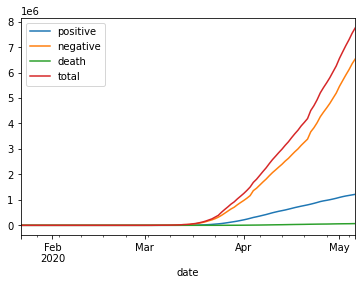

In [13]:
x=gbUSA.sum().loc[:, ['positive', 'negative','death','total']].plot.line()

In [14]:
dfWHO[-14:]

,confirmed,who_deaths
date,,
2020-04-23,800926,40073
2020-04-24,830053,42311
2020-04-25,860772,44053
2020-04-26,899281,46204
2020-04-27,931698,47980
2020-04-28,960916,49170
2020-04-29,983457,50492
2020-04-30,1003974,52428
2020-05-01,1035353,55337


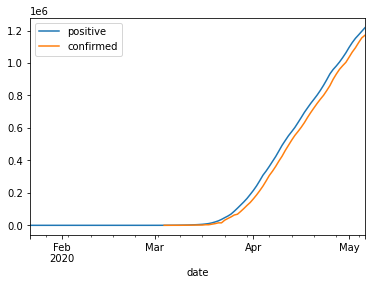

In [15]:
dfResults = gbUSA.sum().join(dfWHO, how='left', rsuffix='_who' )
dfResults.loc[:, ['positive', 'confirmed']].plot.line()

In [16]:
gbCA.sum()[-7:]

,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,recovered,death,hospitalized,total,totalTestResults,posNeg,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
date,,,,,,,,,,,,,,,,,,,,
2020-04-30,26155,122889,0,0.0,5156.0,0.0,1171.0,0.0,0.0,0.0,1120,5156.0,149044,149044,149044,27.0,100.0,4522.0,583.0,5105.0
2020-05-01,27270,141097,0,0.0,5269.0,0.0,1215.0,0.0,0.0,0.0,1154,5269.0,168367,168367,168367,34.0,113.0,18208.0,1115.0,19323.0
2020-05-02,28306,146494,0,0.0,5387.0,0.0,1247.0,0.0,0.0,0.0,1174,5387.0,174800,174800,174800,20.0,118.0,5397.0,1036.0,6433.0
2020-05-03,28602,146494,0,0.0,5393.0,0.0,1249.0,0.0,0.0,0.0,1177,5393.0,175096,175096,175096,3.0,6.0,0.0,296.0,296.0
2020-05-04,29368,153957,0,0.0,5526.0,0.0,1284.0,0.0,0.0,0.0,1222,5526.0,183325,183325,183325,45.0,133.0,7463.0,766.0,8229.0
2020-05-05,29711,171172,0,0.0,5634.0,0.0,1318.0,0.0,0.0,0.0,1288,5634.0,200883,200883,200883,66.0,108.0,17215.0,343.0,17558.0
2020-05-06,30696,173441,0,0.0,5765.0,0.0,1343.0,0.0,0.0,0.0,1311,5765.0,204137,204137,204137,23.0,131.0,2269.0,985.0,3254.0


In [17]:
dfJHUData[dfJHUData.country=='US'][['confirmed', 'dead']].sum()

confirmed    1204351
dead           71064
dtype: int64

In [18]:
dfJHUData[(dfJHUData.country=='US')&(dfJHUData.state=='California')][['confirmed', 'dead']].sum()

confirmed    58456
dead          2381
dtype: int64

In [0]:
dfJHUUS = dfJHUData[dfJHUData.country=='US']
gbJHUByState= dfJHUUS.groupby(by='state')
gbJHUByCountry = dfJHUData.groupby(by='country')

In [20]:
gbJHUByCountry.confirmed.sum().sort_values(ascending=False).head(10)

country
US                1204351
Spain              219329
Italy              213013
United Kingdom     196243
France             170687
Germany            167007
Russia             155370
Turkey             129491
Brazil             115455
Iran                99970
Name: confirmed, dtype: int64

In [0]:
dfData = dfCovidtracking.groupby('date')

In [0]:
dfStateTotal = dfCovidtracking[['state', 'positive']].groupby(by='state').max() \
.rename(columns={'positive':'current_total'})


In [0]:
dfState = dfCovidtracking[['date','state','positive', 'death']].set_index('state') \
  .join(dfStateTotal)

In [0]:
dfState['pct']=dfState.positive/dfState.current_total

In [25]:
dfState.loc['FL'].head(7)

,date,positive,death,current_total,pct
state,,,,,
FL,2020-05-06,38002,1605,38002,1.000000
FL,2020-05-05,37439,1536,38002,0.985185
FL,2020-05-04,36897,1423,38002,0.970923
FL,2020-05-03,36078,1403,38002,0.949371
FL,2020-05-02,35463,1388,38002,0.933188
FL,2020-05-01,34728,1314,38002,0.913847
FL,2020-04-30,33690,1290,38002,0.886532


In [0]:
res = dfState.reset_index().pivot(index = 'date', columns='state', values='pct').fillna(0)

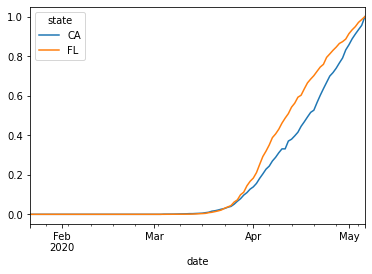

In [27]:
x = res.loc[:, ['CA','FL']].plot.line()

In [0]:
dfNYTesting = dfCovidtracking.loc[dfCovidtracking.state=='NY', ['date', 'negative']].set_index('date')

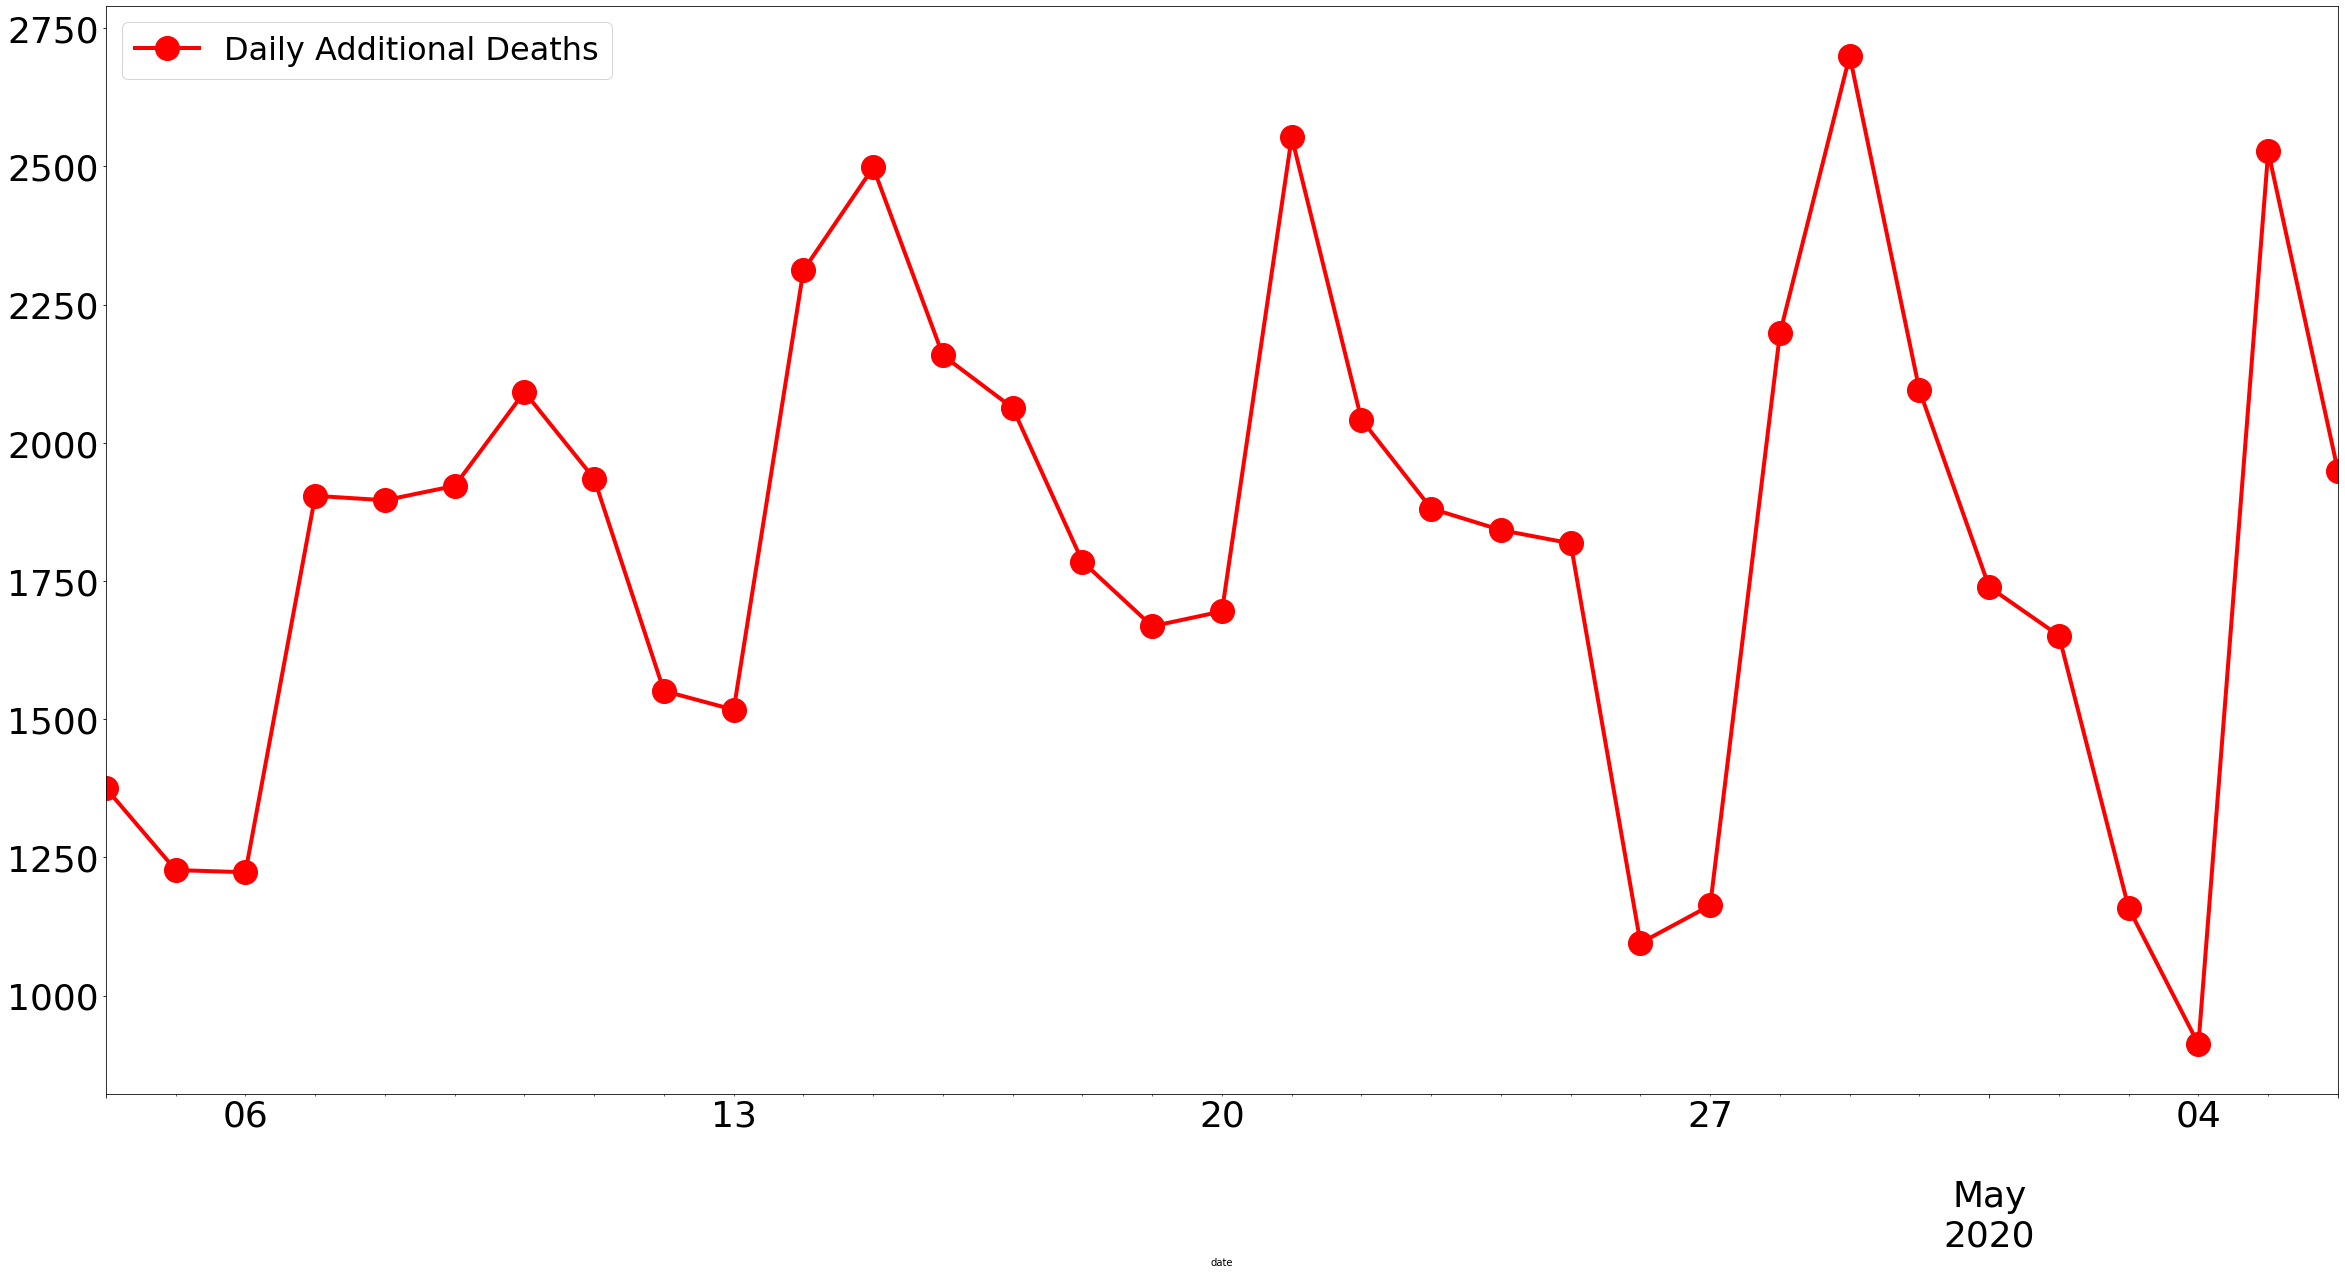

In [29]:
x = dfCovidtracking.groupby(by='date')
y1=x.sum()[-33:].deathIncrease.plot.line(figsize=(40,20), fontsize=36, \
  style='.-', markersize=48, color='red', linewidth=4) \
.legend(['Daily Additional Deaths'],fontsize=32)


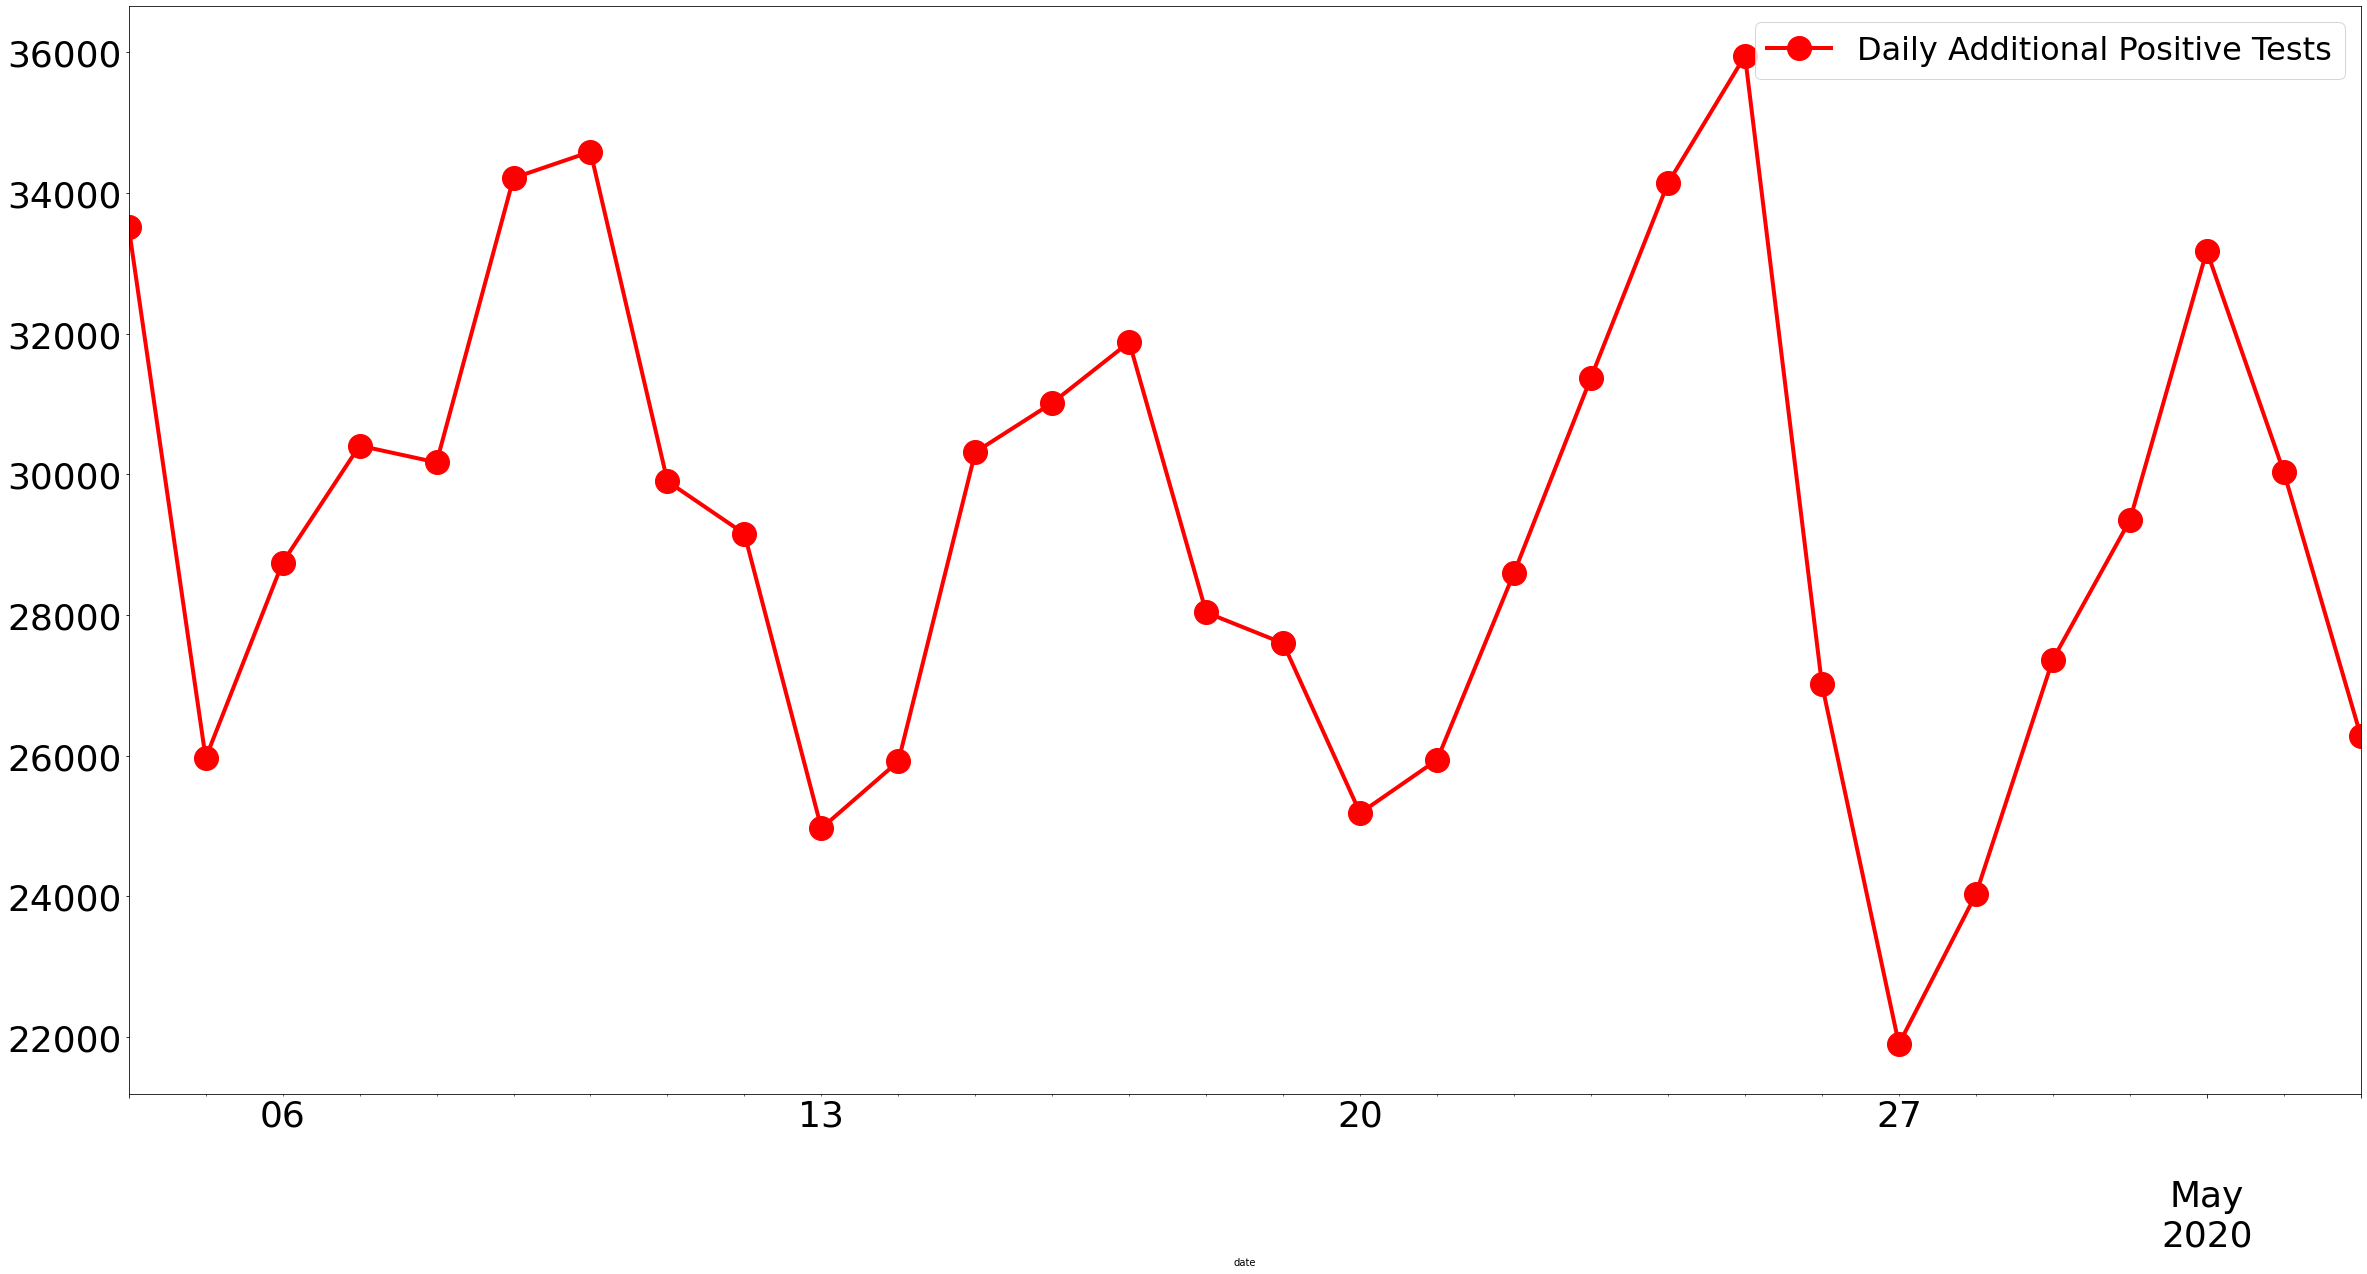

In [30]:
x = dfCovidtracking.groupby(by='date')
y1=x.sum()[-33:-3].positiveIncrease.plot.line(figsize=(40,20), fontsize=36, \
  style='.-', markersize=48, color='red', linewidth=4) \
.legend(['Daily Additional Positive Tests'],fontsize=32)


In [0]:
def getWeek(dt):
  return (dt.year*100)+dt.week

dfByWeekYear = dfCovidtracking.set_index('date')[['deathIncrease', 'hospitalizedIncrease', 'negativeIncrease','positiveIncrease','totalTestResultsIncrease']].groupby(by=getWeek)


In [0]:
def getWeek(dt):
  return (dt.year*100)+dt.week

dfDoW = dfCovidtracking.set_index('date')[['deathIncrease', 'hospitalizedIncrease', 'negativeIncrease','positiveIncrease','totalTestResultsIncrease']].groupby(by=lambda x: x.dayofweek)


In [33]:
dfDoW.sum().deathIncrease



0     7156.0
1    12542.0
2    12294.0
3     9491.0
4     9373.0
5     9061.0
6     7339.0
Name: deathIncrease, dtype: float64

In [34]:
dfCovidtracking.set_index('date')[['deathIncrease', 'hospitalizedIncrease', 'negativeIncrease','positiveIncrease','totalTestResultsIncrease']]


,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
date,,,,,
2020-05-06,1.0,0.0,962.0,1.0,963.0
2020-05-06,27.0,51.0,2454.0,296.0,2750.0
2020-05-06,5.0,0.0,4296.0,72.0,4368.0
2020-05-06,0.0,0.0,0.0,0.0,0.0
2020-05-06,31.0,33.0,3075.0,402.0,3477.0
...,...,...,...,...,...
2020-01-26,0.0,0.0,0.0,0.0,0.0
2020-01-25,0.0,0.0,0.0,0.0,0.0
2020-01-24,0.0,0.0,0.0,0.0,0.0


In [35]:
dfByWeekYear.sum()[:-1]

,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
202004,0.0,0.0,0.0,0.0,0.0
202005,0.0,0.0,0.0,0.0,0.0
202006,0.0,0.0,0.0,1.0,1.0
202007,0.0,0.0,0.0,0.0,0.0
202008,0.0,0.0,0.0,0.0,0.0
202009,8.0,0.0,81.0,28.0,109.0
202010,23.0,0.0,2821.0,595.0,3416.0
202011,46.0,0.0,30203.0,4114.0,34317.0
202012,359.0,2498.0,179297.0,31482.0,210779.0
202013,2091.0,13766.0,497952.0,107963.0,605915.0


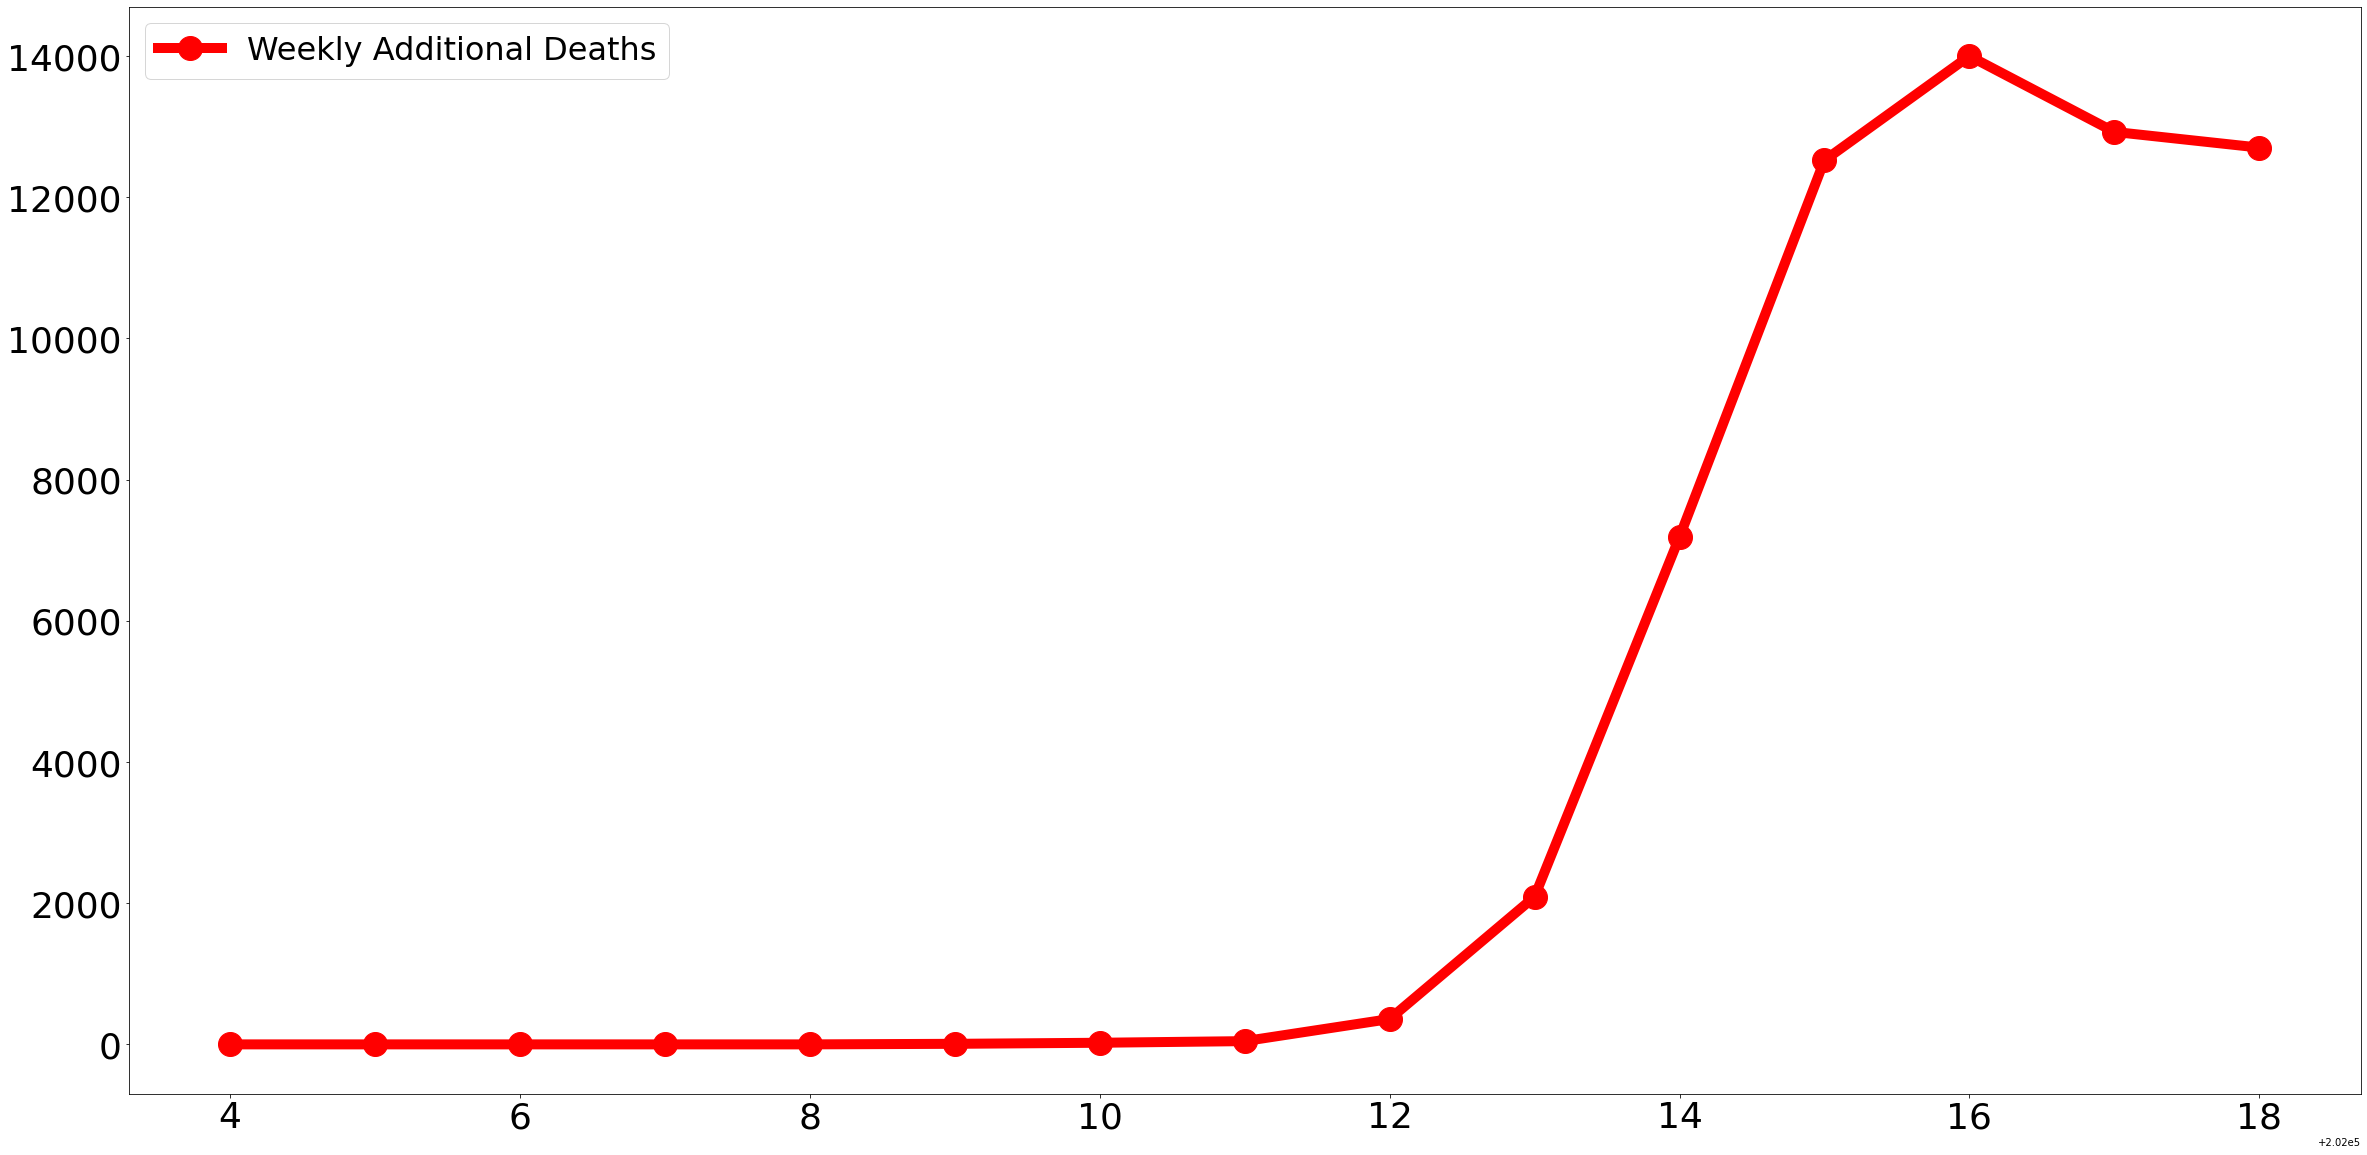

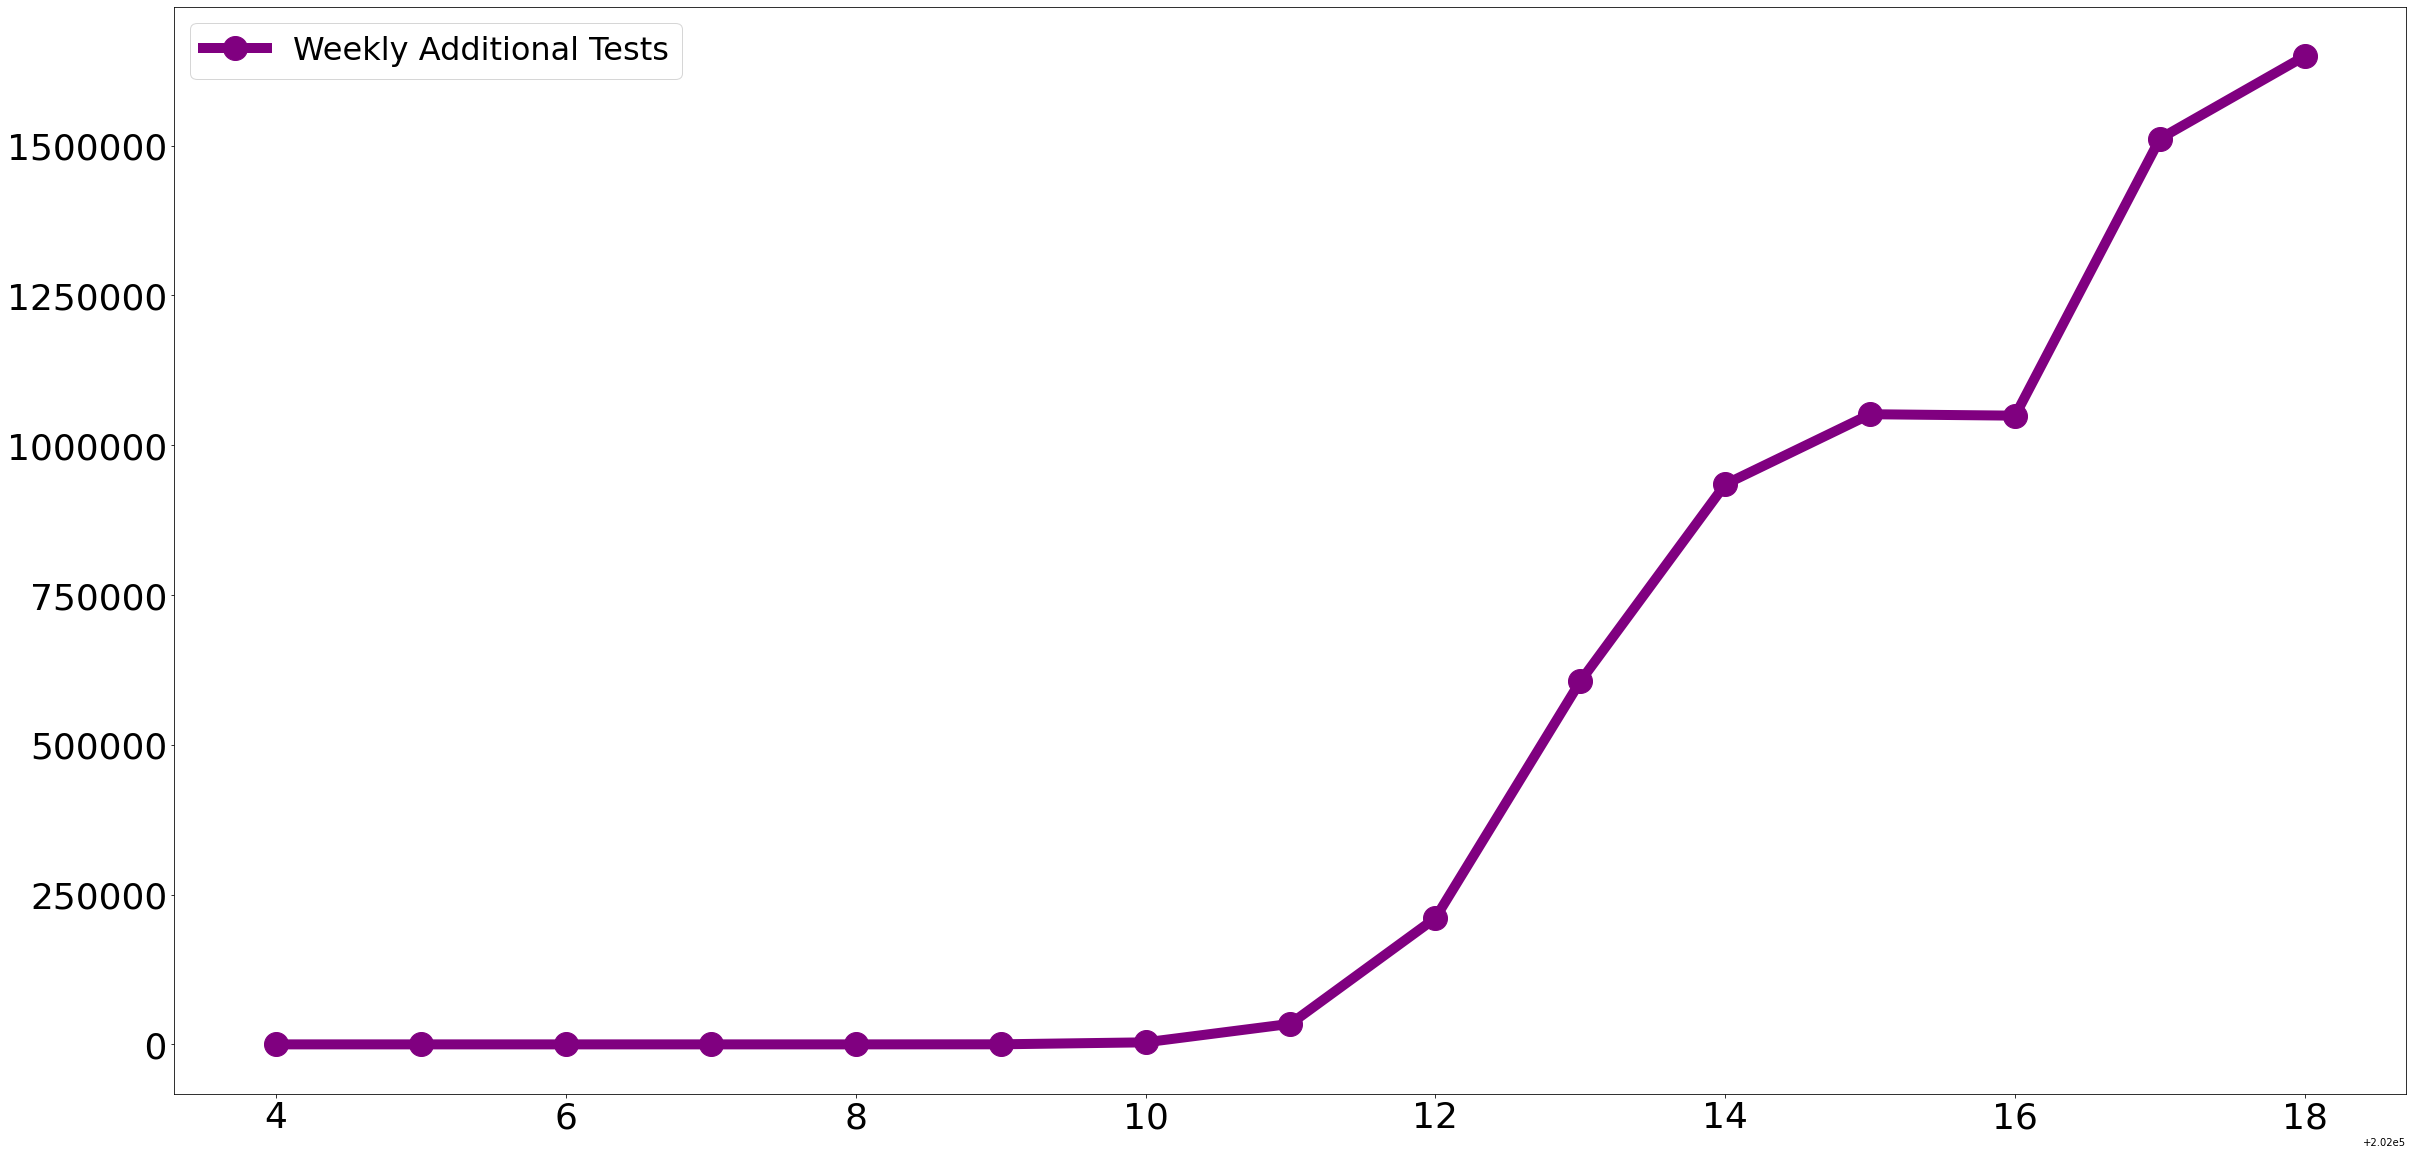

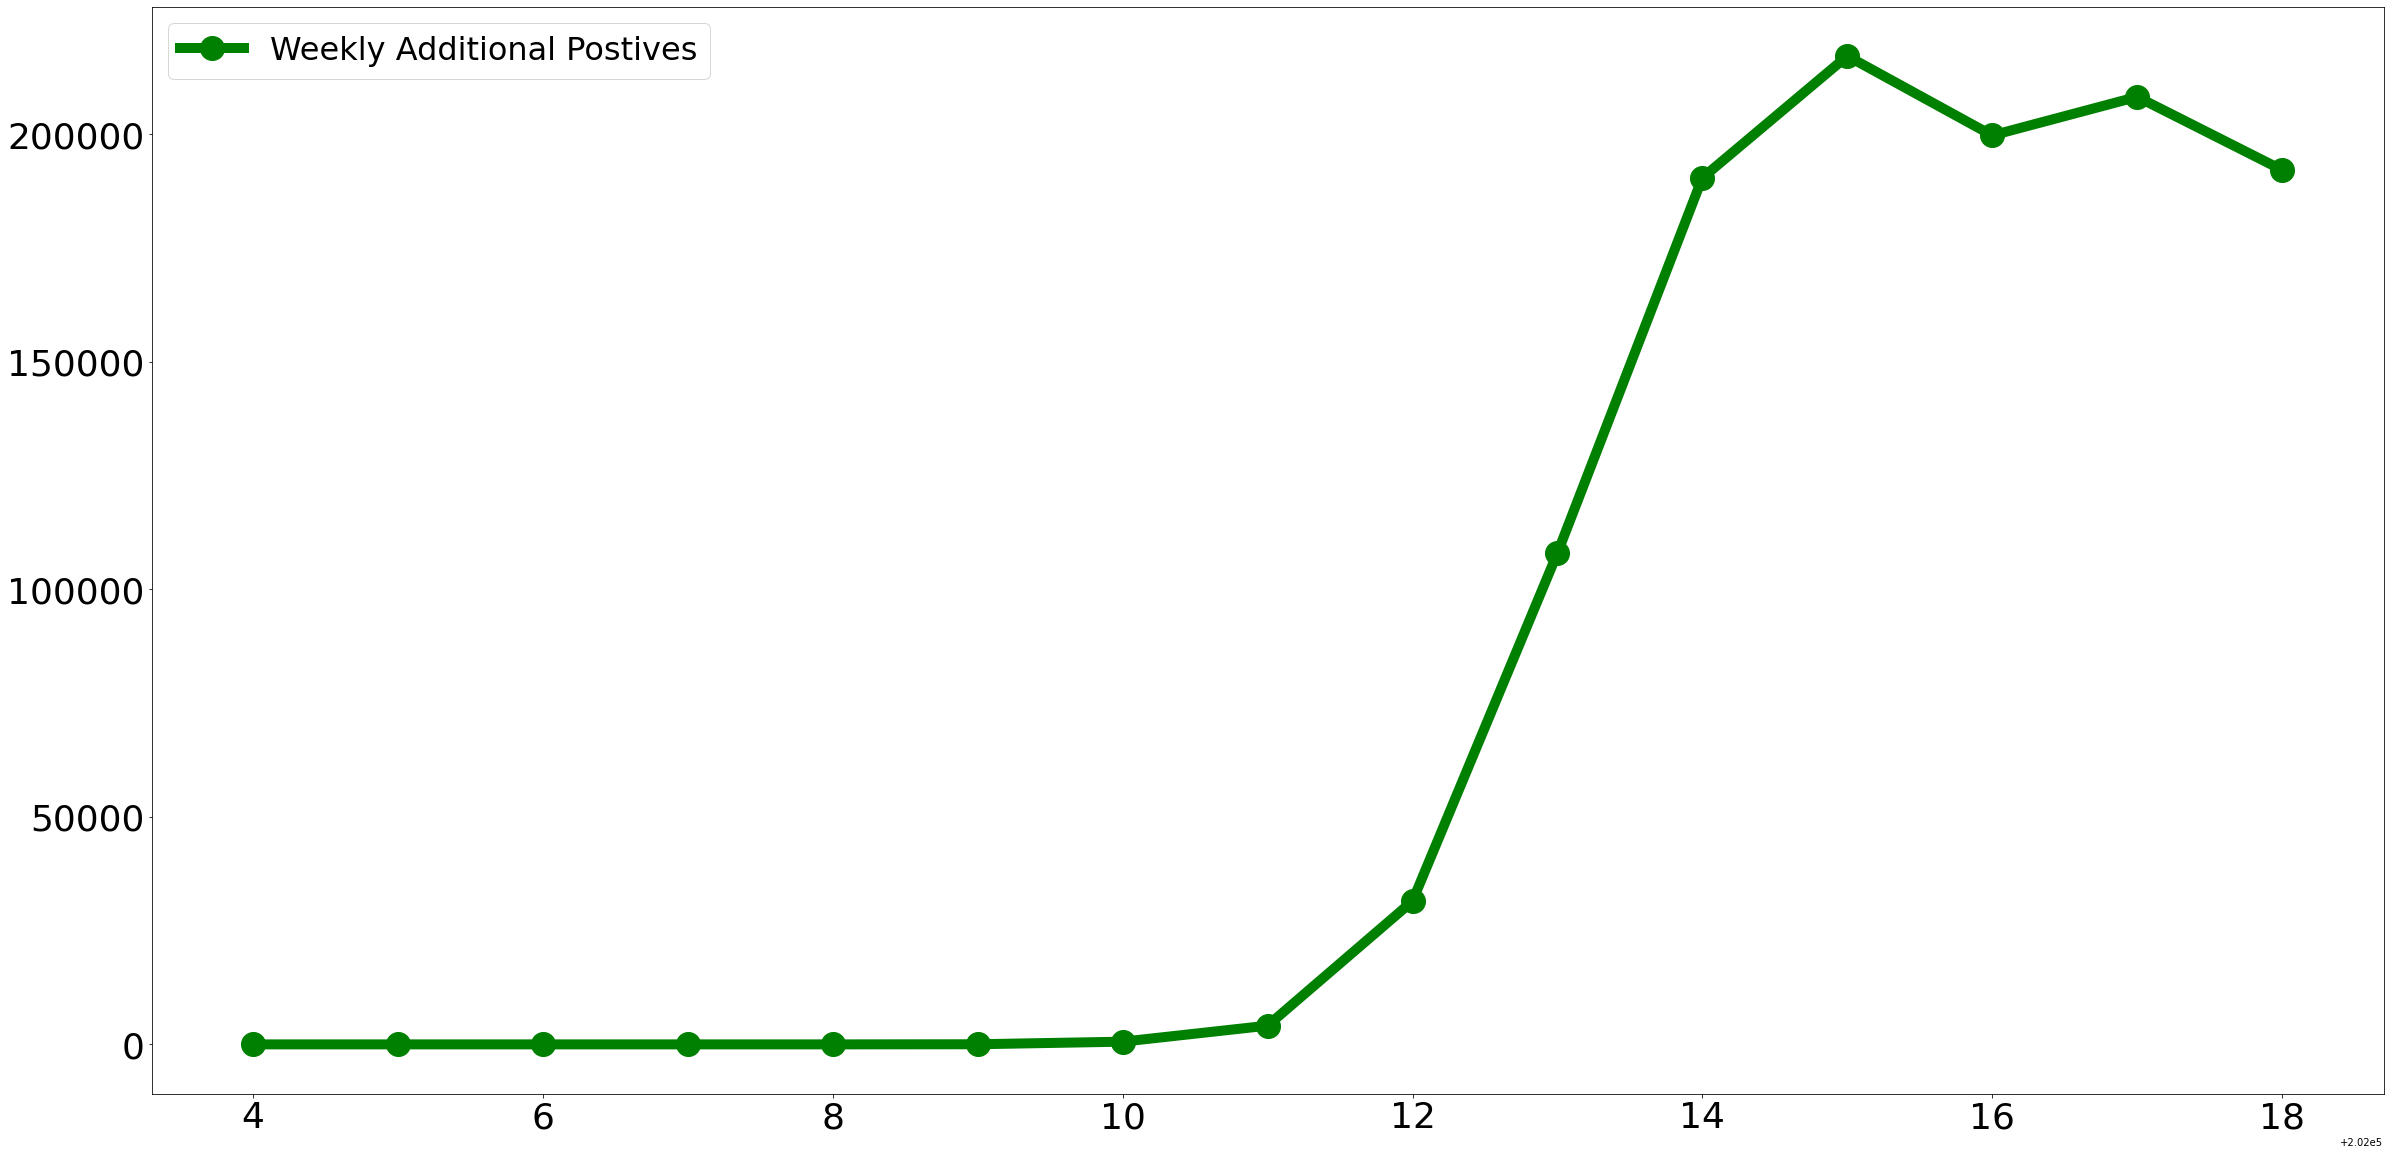

In [36]:
import matplotlib.ticker as ticker
plt1 = dfByWeekYear.sum()[:-1][['deathIncrease']].plot.line(figsize=(40,20), \
    fontsize=36, style='.-', markersize=48, linewidth=10, color='red')
plt1.legend(['Weekly Additional Deaths'],fontsize=32)
plt2 = dfByWeekYear.sum()[:-1][['totalTestResultsIncrease']].plot.line(figsize=(40,20), \
    fontsize=36, style='.-', markersize=48, linewidth=10, color='purple')
plt2.legend(['Weekly Additional Tests'],fontsize=32)

plt2.yaxis.set_major_formatter(ticker.FormatStrFormatter('%6.0d'))
    
plt3 = dfByWeekYear.sum()[:-1][['positiveIncrease']].plot.line(figsize=(40,20), \
    fontsize=36, style='.-', markersize=48, linewidth=10, color='green')
plt3.legend(['Weekly Additional Postives'],fontsize=32)

In [37]:
dfDates = dfState.reset_index().copy()
dfDates[(dfDates.state.isin(['FL']))].head(10)

,state,date,positive,death,current_total,pct
614,FL,2020-05-06,38002,1605,38002,1.000000
615,FL,2020-05-05,37439,1536,38002,0.985185
616,FL,2020-05-04,36897,1423,38002,0.970923
617,FL,2020-05-03,36078,1403,38002,0.949371
618,FL,2020-05-02,35463,1388,38002,0.933188
619,FL,2020-05-01,34728,1314,38002,0.913847
620,FL,2020-04-30,33690,1290,38002,0.886532
621,FL,2020-04-29,33193,1240,38002,0.873454
622,FL,2020-04-28,32846,1154,38002,0.864323
623,FL,2020-04-27,32138,1101,38002,0.845692


In [70]:
datecutoff = dfDates.date.max()-datetime.timedelta(days=5)
dfDates[(dfDates.date == datecutoff) & (dfDates.pct < .7)].sort_values(by='pct')


,state,date,positive,death,current_total,pct
1963,NE,2020-05-01,4281,70,6438,0.664958
1541,MN,2020-05-01,5730,371,8579,0.667910


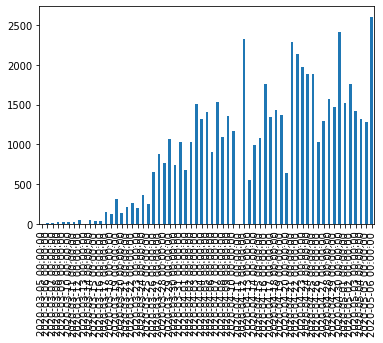

In [39]:
state = 'CA'
dfState = dfCovidtracking[dfCovidtracking.state==state].sort_values(by='date')
vals = dfState.positive.values

x=pd.Series([y-x for x,y in zip(vals,vals[1:])], \
          index = dfCovidtracking[dfCovidtracking.state==state]\
          .sort_values(by='date').date.values[1:] ) \
          .plot.bar()



# Added State Data

In [0]:
data_url = "https://www2.census.gov/programs-surveys/popest/datasets/2010-2019/national/totals/nst-est2019-alldata.csv"


In [0]:
dfUSPop = pd.read_csv(data_url)

In [42]:
import math
us_pop = dfUSPop.loc[0].POPESTIMATE2019 #Estimate from Wikipedia
res = dfCovidtracking.loc[dfCovidtracking.date==dfCovidtracking.date.max(), ['positive', 'negative', 'pending','death', 'total']].sum()
cir = res.positive/res.total
cfr = res.death/res.positive
p_aff= math.ceil(us_pop*cir)
p_dead= math.ceil(p_aff*cfr)
print(res)
print(f"Current Infection Rate {cir*100:2f}%")
print(f"Percentage of US affected: {(res.positive+res.death)/us_pop*100:2f}%")
print(f"Observed CFR: {cfr*100:2f}%")
print(f"Percentage of US tested/affected: {(res.negative+res.positive+res.death)/us_pop*100:2f}%")
print(f"Projected affected by cir = {p_aff:,d}")
print(f"Projected killed = {p_dead:,d}")


positive    1217771
negative    6542000
pending        2742
death         67256
total       7762513
dtype: int64
Current Infection Rate 15.687845%
Percentage of US affected: 0.391491%
Observed CFR: 5.522877%
Percentage of US tested/affected: 2.384547%
Projected affected by cir = 51,493,708
Projected killed = 2,843,935


In [0]:
!if [ ! -d "loc" ]; then \
git clone https://gist.github.com/rogerallen/1583593 --depth=1 --quiet loc; \
fi
import sys
sys.path.append("loc")




In [0]:
import us_state_abbrev as us_abbr


In [0]:
dfStatePop = dfUSPop[dfUSPop.STATE != 0].copy()

In [0]:
dfStatePop['ABBR']=dfStatePop.NAME.apply(lambda x: us_abbr.us_state_abbrev[x])

In [0]:
dfStatePop = dfStatePop.loc[:, ['ABBR', 'POPESTIMATE2019']]
dfStatePop.set_index('ABBR', inplace=True)

In [0]:
dfStateCovid = dfCovidtracking.loc[dfCovidtracking.date==dfCovidtracking.date.max()].set_index('state')

In [0]:
dfStateJoin = dfStateCovid.join(dfStatePop)

In [50]:
pd.DataFrame([(dfStateJoin.positive / dfStateJoin.POPESTIMATE2019)*100, \
              (dfStateJoin.totalTestResults/ dfStateJoin.POPESTIMATE2019)*100],\
             index=['state_pos_pop','state_test_pop'] ).T.sort_values(by="state_pos_pop", ascending=False)[:51]

,state_pos_pop,state_test_pop
state,,
NY,1.651070,5.289001
NJ,1.484882,3.252801
MA,1.044976,4.927658
RI,0.963317,7.492536
CT,0.869355,3.125891
DC,0.773788,3.540069
LA,0.653912,4.187581
DE,0.593368,2.718112
IL,0.538455,2.850893


In [51]:
#print(f"Current Infection Rate {res.positive/res.total*100:2f}%")

print(f"Current Testing Percent {gbUSA.sum().tail(1).totalTestResults[0]/dfUSPop[dfUSPop.REGION=='0'].POPESTIMATE2019[0]*100:2f}%")

Current Testing Percent 2.364057%


In [52]:
dfJHUData.columns

Index(['FIPS', 'city', 'state', 'country', 'last_update', 'lat', 'lon',
       'confirmed', 'dead', 'recovered', 'active', 'key'],
      dtype='object')

In [0]:
dfOwid = pd.read_csv("https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv")

In [54]:
dfOwid.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15547 entries, 0 to 15546
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   iso_code                  15355 non-null  object 
 1   location                  15547 non-null  object 
 2   date                      15547 non-null  object 
 3   total_cases               15547 non-null  int64  
 4   new_cases                 15547 non-null  int64  
 5   total_deaths              15547 non-null  int64  
 6   new_deaths                15547 non-null  int64  
 7   total_cases_per_million   15250 non-null  float64
 8   new_cases_per_million     15250 non-null  float64
 9   total_deaths_per_million  15250 non-null  float64
 10  new_deaths_per_million    15250 non-null  float64
 11  total_tests               3986 non-null   float64
 12  new_tests                 3563 non-null   float64
 13  total_tests_per_thousand  3986 non-null   float64
 14  new_te

In [0]:
dfOwidTests = dfOwid.dropna(subset=['total_tests']).copy()

In [0]:
dfOwidLatest = dfOwidTests.sort_values(by='date').groupby('iso_code').last()

In [57]:
dfOwidLatest.total_tests.sort_values(ascending=False)

iso_code
USA    7544328.0
RUS    4633731.0
DEU    2755770.0
ITA    2310929.0
ESP    1351130.0
         ...    
NPL      13850.0
PRY      11898.0
CRI       9892.0
MMR       9295.0
BOL       7888.0
Name: total_tests, Length: 84, dtype: float64

In [58]:
isUSA = dfOwidLatest.index.isin(['USA'])
NonUSTests = dfOwidLatest[~isUSA].total_tests.sum()
USTests = dfOwidLatest[isUSA].total_tests.sum()

print(f"Total testing done outside of USA: {NonUSTests:.0f}")
print(f"Total tests done in USA : {USTests:.0f}")
print(f"How many more times has the world tested more than the US: {NonUSTests/USTests:.1f}")

Total testing done outside of USA: 28164293
Total tests done in USA : 7544328
How many more times has the world tested more than the US: 3.7


In [59]:
dfOwidLatest[isUSA].sum()

location                                                  United States
date                                                         2020-05-05
total_cases                                                     1180634
new_cases                                                         22593
total_deaths                                                      68934
new_deaths                                                         1252
total_cases_per_million                                         3566.84
new_cases_per_million                                            68.256
total_deaths_per_million                                        208.258
new_deaths_per_million                                            3.782
total_tests                                                 7.54433e+06
new_tests                                                        258954
total_tests_per_thousand                                         22.792
new_tests_per_thousand                                          

In [60]:
dfOwidUSA = dfOwid.loc[dfOwid.iso_code=='USA']
dfOwidUSA.set_index('date')[['new_cases','new_deaths']][-14:]

,new_cases,new_deaths
date,,
2020-04-23,17588,1721
2020-04-24,26543,3179
2020-04-25,21352,1054
2020-04-26,48529,2172
2020-04-27,26857,1687
2020-04-28,22541,1369
2020-04-29,24132,2110
2020-04-30,27326,2611
2020-05-01,29917,2040


In [61]:
dfOwidUSA.set_index('date')

,iso_code,location,total_cases,new_cases,total_deaths,new_deaths,total_cases_per_million,new_cases_per_million,total_deaths_per_million,new_deaths_per_million,total_tests,new_tests,total_tests_per_thousand,new_tests_per_thousand,tests_units
date,,,,,,,,,,,,,,,
2019-12-31,USA,United States,0,0,0,0,0.000,0.000,0.000,0.000,NaN,NaN,NaN,NaN,NaN
2020-01-01,USA,United States,0,0,0,0,0.000,0.000,0.000,0.000,NaN,NaN,NaN,NaN,NaN
2020-01-02,USA,United States,0,0,0,0,0.000,0.000,0.000,0.000,NaN,NaN,NaN,NaN,NaN
2020-01-03,USA,United States,0,0,0,0,0.000,0.000,0.000,0.000,NaN,NaN,NaN,NaN,NaN
2020-01-04,USA,United States,0,0,0,0,0.000,0.000,0.000,0.000,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-05-02,USA,United States,1103781,33955,65068,2062,3334.659,102.582,196.578,6.230,6805241.0,253431.0,20.559,0.766,inconsistent units (COVID Tracking Project)
2020-05-03,USA,United States,1133069,29288,66385,1317,3423.142,88.483,200.557,3.979,7053366.0,248125.0,21.309,0.750,inconsistent units (COVID Tracking Project)
2020-05-04,USA,United States,1158041,24972,67682,1297,3498.585,75.444,204.476,3.918,7285374.0,232008.0,22.010,0.701,inconsistent units (COVID Tracking Project)


In [62]:
dfCovidtracking.head()

,date,state,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,recovered,dataQualityGrade,lastUpdateEt,hash,dateChecked,death,hospitalized,total,totalTestResults,posNeg,fips,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
0,2020-05-06,AK,372,23283,0,8.0,0.0,0.0,0.0,0.0,0.0,284.0,C,5/6/2020 00:00,fc9f98fdf2f0db7f59fd92efea605ccca134259e,2020-05-06T20:00:00Z,10,0.0,23655,23655,23655,02,1.0,0.0,962.0,1.0,963.0
1,2020-05-06,AL,8581,100935,0,0.0,1158.0,0.0,442.0,0.0,264.0,0.0,B,5/6/2020 00:00,cda808b17675c452da77c0e6b5aaf56a5f434a0e,2020-05-06T20:00:00Z,340,1158.0,109516,109516,109516,01,27.0,51.0,2454.0,296.0,2750.0
2,2020-05-06,AR,3568,55435,0,69.0,453.0,0.0,0.0,14.0,89.0,2109.0,B,5/6/2020 14:42,cb92db297b9f3a9418a5a0bf6439bf95106cc319,2020-05-06T20:00:00Z,85,453.0,59003,59003,59003,05,5.0,0.0,4296.0,72.0,4368.0
3,2020-05-06,AS,0,83,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,F,5/3/2020 00:00,ba86f4ccd459fbd32fadda9d5a86774440b0d3ee,2020-05-06T20:00:00Z,0,0.0,83,83,83,60,0.0,0.0,0.0,0.0,0.0
4,2020-05-06,AZ,9707,82030,0,754.0,1430.0,286.0,0.0,193.0,0.0,1693.0,A+,5/6/2020 00:00,3c805a6c16888efca84885003f9697d2f9b99141,2020-05-06T20:00:00Z,426,1430.0,91737,91737,91737,04,31.0,33.0,3075.0,402.0,3477.0


In [0]:
dfWeeklyFL = dfCovidtracking.loc[dfCovidtracking.state=='FL'].set_index('date')\
.groupby(by=lambda x: x.week).sum()


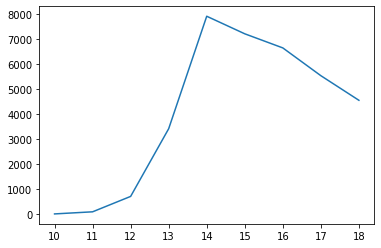

In [64]:
plt = dfWeeklyFL[:-1].positiveIncrease.plot.line()

In [65]:
dfJHUData[dfJHUData.state=='Florida'].confirmed.sum()

37439

In [66]:
dfCovidtracking[dfCovidtracking.state=='FL']

,date,state,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,recovered,dataQualityGrade,lastUpdateEt,hash,dateChecked,death,hospitalized,total,totalTestResults,posNeg,fips,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
10,2020-05-06,FL,38002,442049,1351,0.0,6776.0,0.0,0.0,0.0,0.0,0.0,C,5/6/2020 09:45,ef53ede20479581dcab76508f0c672a9542fe387,2020-05-06T20:00:00Z,1605,6776.0,481402,480051,480051,12,69.0,230.0,13797.0,563.0,14360.0
66,2020-05-05,FL,37439,428252,1265,0.0,6546.0,0.0,0.0,0.0,0.0,0.0,C,5/5/2020 10:31,cc9858355edd3f9217a9161416e34034e40cfd24,2020-05-05T20:00:00Z,1536,6546.0,466956,465691,465691,12,113.0,217.0,20879.0,542.0,21421.0
122,2020-05-04,FL,36897,407373,1181,0.0,6329.0,0.0,0.0,0.0,0.0,0.0,C,5/4/2020 09:12,ab9900a3978e419e37fd28c4c86ff5943dbb92e4,2020-05-04T20:00:00Z,1423,6329.0,445451,444270,444270,12,20.0,85.0,15262.0,819.0,16081.0
178,2020-05-03,FL,36078,392111,1226,0.0,6244.0,0.0,0.0,0.0,0.0,0.0,C,5/2/2020 10:14,b4bbb1861dfd7382b14b352add108a733db9e3c3,2020-05-03T20:00:00Z,1403,6244.0,429415,428189,428189,12,15.0,299.0,11562.0,615.0,12177.0
234,2020-05-02,FL,35463,380549,0,0.0,5945.0,0.0,0.0,0.0,0.0,0.0,C,5/2/2020 10:14,6fef4afbf7bffe883ca0cecf9eb9683715d5781b,2020-05-02T20:00:00Z,1388,5945.0,416012,416012,416012,12,74.0,150.0,12578.0,735.0,13313.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3275,2020-03-08,FL,17,118,108,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,6fe85d0dc53d6860063f38e98dccf29e36f035c3,2020-03-08T20:00:00Z,0,0.0,243,135,135,12,0.0,0.0,18.0,3.0,21.0
3325,2020-03-07,FL,14,100,88,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,78b1ecd25b46274b2fb969cd705c9ce078f24642,2020-03-07T21:00:00Z,0,0.0,202,114,114,12,0.0,0.0,45.0,5.0,50.0
3373,2020-03-06,FL,9,55,51,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,6b75ea058687eb6f8643e53e3f75f8739b986534,2020-03-06T21:00:00Z,0,0.0,115,64,64,12,0.0,0.0,24.0,0.0,24.0
3406,2020-03-05,FL,9,31,69,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,be40a4f79a747d11e86a789e72624d9fb7e87651,2020-03-05T21:00:00Z,0,0.0,109,40,40,12,0.0,0.0,7.0,7.0,14.0


In [0]:
doWGA = dfCovidtracking[dfCovidtracking.state=='GA'].set_index('date')[['deathIncrease', 'hospitalizedIncrease', 'negativeIncrease','positiveIncrease','totalTestResultsIncrease']]\
.groupby(lambda x: x.dayofweek)

In [68]:
doWGA.sum()

,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
0,208.0,715.0,20005.0,3811.0,23816.0
1,355.0,1218.0,39541.0,5795.0,45336.0
2,247.0,1438.0,21047.0,5634.0,26681.0
3,156.0,745.0,20163.0,3789.0,23952.0
4,195.0,868.0,32762.0,5295.0,38057.0
5,90.0,579.0,25740.0,3544.0,29284.0
6,60.0,202.0,14183.0,2826.0,17009.0
